In [1]:
import json

# Load data from the JSON file
with open('51n.json', 'r') as f:
    data = json.load(f)

# Extract main bounding box
main_box_data = data['boundingBox']
main_box = [
    main_box_data['sw']['latitude'],
    main_box_data['sw']['longitude'],
    main_box_data['ne']['latitude'],
    main_box_data['ne']['longitude']
]

# Extract solar panel data
solarPotential_data = data['solarPotential']
solar_panels_data = solarPotential_data.get('solarPanels', [])
solarPotential_structure = {key: type(value).__name__ for key, value in solarPotential_data.items()}

# Print the number of solar panels
#print(f"Number of solar panels: {len(solar_panels_data)}")

# Extract roof segment statistics
roofSegmentStats_data = solarPotential_data.get('roofSegmentStats', [])

bounding_box_data = data['boundingBox']

# Extract heights of each sample and store in a list
sample_heights = []
for i, segment in enumerate(roofSegmentStats_data):
    height = segment.get('planeHeightAtCenterMeters', None)
    if height is not None:
        sample_heights.append(height)

# Extract sample boxes
sample_boxes = []
for sample in roofSegmentStats_data:
    box = sample.get('boundingBox', {})
    sw = box.get('sw', {})
    ne = box.get('ne', {})
    sample_box = [
        sw.get('latitude', None),
        sw.get('longitude', None),
        ne.get('latitude', None),
        ne.get('longitude', None)
    ]
    sample_boxes.append(sample_box)

# Dimensions of a single solar panel in inches
panel_width = 60
panel_height = 70

In [2]:
bounding_box_data = data['boundingBox']
bounding_box_structure = {key: type(value).__name__ for key, value in bounding_box_data.items()}
print(bounding_box_structure)

{'sw': 'dict', 'ne': 'dict'}


In [5]:
import sympy as sp
import math
import numpy as np
from sympy import symbols, solve, Eq, sqrt

def find_rectangle_vertices(NE, SW, Area):
    # Average latitude for North America (example: 40 degrees North)
    average_latitude = 35

    # Constants for distance calculations
    METERS_PER_DEGREE_LAT = 111000  # Approximate meters per degree of latitude
    METERS_PER_DEGREE_LON = METERS_PER_DEGREE_LAT * math.cos(math.radians(average_latitude))

    # Extract latitude and longitude from NE and SW
    lat1, lon1 = SW
    lat2, lon2 = NE

    # Calculate the center of the line AB
    lat_center = (lat1 + lat2) / 2
    lon_center = (lon1 + lon2) / 2

    # Calculate the distances between the latitudes and longitudes
    distance_lat = (lat2 - lat1) * METERS_PER_DEGREE_LAT
    distance_lon = (lon2 - lon1) * METERS_PER_DEGREE_LON

    # Calculate the actual distance d between A and B using the Pythagorean theorem
    d = sp.sqrt(distance_lat**2 + distance_lon**2)

    # Define the symbols for width (w) and height (h)
    w, h = sp.symbols('w h', real=True)

    # Equation for the area and diagonal of the rectangle
    eq_area = sp.Eq(w * h, Area)
    eq_diag = sp.Eq(w**2 + h**2, d**2)

    # Solve the system of equations
    solutions = sp.solve((eq_area, eq_diag), (w, h))

    # Initialize an empty list to store the rectangle vertices
    rectangles = []

    # Check if there are any solutions
    if solutions:
        # Take the solution with the positive width and height
        width, height = next((sol for sol in solutions if sol[0] > 0 and sol[1] > 0), (None, None))

        # Define symbols for point C (x3, y3)
        lat3, lon3 = sp.symbols('lat3 lon3', real=True)

         # Equations based on the rectangle's sides and Pythagorean theorem
        eq1 = Eq ((lat3 - lat1)**2 * METERS_PER_DEGREE_LAT**2 + (lon3 - lon1)**2 * METERS_PER_DEGREE_LON**2, height**2)
        eq2 = Eq ((lat3 - lat2)**2 * METERS_PER_DEGREE_LAT**2 + (lon3 - lon2)**2 * METERS_PER_DEGREE_LON**2, width**2)
        # Equation for 90-degree angles using dot product of vectors AB and AC
        #eq3 = Eq ((lat3 - lat1) * (lat3 - lat2)* METERS_PER_DEGREE_LAT**2 + (lon3 - lon1) * (lon3 - lon2)* METERS_PER_DEGREE_LON**2, 0)

        # Solve the equations to find point C
        solution_for_C = sp.solve((eq1, eq2), (lat3, lon3))

        # Calculate points C and D for each solution
        for C in solution_for_C:
            lat3, lon3 = C
            lat4 = 2 * lat_center - lat3
            lon4 = 2 * lon_center - lon3
            D = (lat4, lon4)
            rectangles.append(((lat1, lon1), (lat2, lon2), C, D))

    return rectangles

# Example usage
NE = (42.271236699999996, -71.0848022)
SW = (42.271187999999995, -71.0849068)
Area = 20

results = find_rectangle_vertices(NE, SW, Area)
results[0]

((42.271187999999995, -71.0849068),
 (42.271236699999996, -71.0848022),
 (42.2711750813400, -71.0848938569970),
 (42.2712496186600, -71.0848151430030))

In [6]:
# Extract the southwest and northeast points
sw_lat = data['boundingBox']['sw']['latitude']
sw_lon = data['boundingBox']['sw']['longitude']
ne_lat = data['boundingBox']['ne']['latitude']
ne_lon = data['boundingBox']['ne']['longitude']

# Extract the area from the solarPotential
area = data['solarPotential']['wholeRoofStats']['areaMeters2']

# Convert these points into a format suitable for your function
# Assuming find_rectangle_vertices accepts southwest and northeast points as tuples and the area as a float
sw_point = (sw_lat, sw_lon)
ne_point = (ne_lat, ne_lon)

# Now you can call your find_rectangle_vertices function
# Here's a placeholder for how the call might look, but it depends on the actual signature of your function
vertices = find_rectangle_vertices(SW=sw_point, NE=ne_point, Area=area)

In [14]:
sample 

{'pitchDegrees': 24.406351,
 'azimuthDegrees': 159.37352,
 'stats': {'areaMeters2': 25.707256,
  'sunshineQuantiles': [747,
   1038,
   1293,
   1482,
   1512,
   1514,
   1516,
   1518,
   1522,
   1526,
   1530],
  'groundAreaMeters2': 23.41},
 'center': {'latitude': 42.2712137, 'longitude': -71.08485329999999},
 'boundingBox': {'sw': {'latitude': 42.271187999999995,
   'longitude': -71.0849068},
  'ne': {'latitude': 42.271236699999996, 'longitude': -71.0848022}},
 'planeHeightAtCenterMeters': 16.634693}

In [15]:
import pandas as pd

# Create a list to hold dictionaries for each row
data_rows = []

# Loop through each sample in the JSON data
for sample in roofSegmentStats_data:
    # Extract the bounding box and the area from the sample
    SW_lat = sample['boundingBox']['sw']['latitude']
    SW_lon = sample['boundingBox']['sw']['longitude']
    NE_lat = sample['boundingBox']['ne']['latitude']
    NE_lon = sample['boundingBox']['ne']['longitude']
    Area = sample['stats']['areaMeters2']
    sample_height = sample['planeHeightAtCenterMeters']
    
    # Convert SW and NE to tuples
    SW = (SW_lat, SW_lon)
    NE = (NE_lat, NE_lon)
    
    # Calculate the rectangle vertices using the function
    rectangle_vertices = find_rectangle_vertices(NE, SW, Area)
    
    # Check if two results are found and append them to the list with labels
    if rectangle_vertices and len(rectangle_vertices) == 2:
        data_rows.append({
            'Label': '1',
            'A': rectangle_vertices[0][0],
            'B': rectangle_vertices[0][1],
            'C': rectangle_vertices[0][2],
            'D': rectangle_vertices[0][3],
            'Sampleheight': sample_height
        })
        data_rows.append({
            'Label': '2',
            'A': rectangle_vertices[1][0],
            'B': rectangle_vertices[1][1],
            'C': rectangle_vertices[1][2],
            'D': rectangle_vertices[1][3],
            'Sampleheight': sample_height
        })

# Create a DataFrame from the list of dictionaries
df_results = pd.DataFrame(data_rows)

# Display the DataFrame
print(df_results)

   Label                                         A  \
0      1         (42.271187999999995, -71.0849068)   
1      2         (42.271187999999995, -71.0849068)   
2      1         (42.271228099999995, -71.0849289)   
3      2         (42.271228099999995, -71.0849289)   
4      1  (42.271233699999996, -71.08487250000002)   
5      2  (42.271233699999996, -71.08487250000002)   
6      1                 (42.2712703, -71.0849361)   
7      2                 (42.2712703, -71.0849361)   
8      1                  (42.2711889, -71.084957)   
9      2                  (42.2711889, -71.084957)   
10     1          (42.2712104, -71.08491529999999)   
11     2          (42.2712104, -71.08491529999999)   

                                    B                                      C  \
0   (42.271236699999996, -71.0848022)  (42.2711719564636, -71.0848889572547)   
1   (42.271236699999996, -71.0848022)  (42.2712087666768, -71.0849144981766)   
2    (42.2712808, -71.08485449999999)  (42.2712155875665,

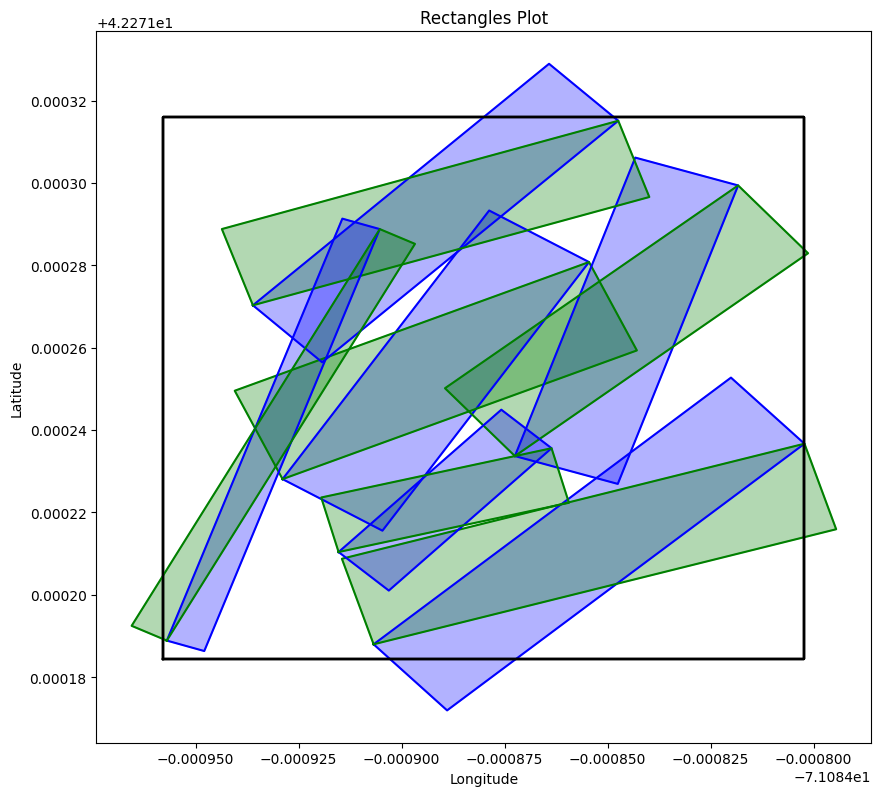

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

main_box_data = data['boundingBox']
main_box = [
    main_box_data['sw']['latitude'],
    main_box_data['sw']['longitude'],
    main_box_data['ne']['latitude'],
    main_box_data['ne']['longitude']
]


def draw_rectangles(df):
    # Create a new figure and axis for the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Define colors for each label
    color_map = {1: 'blue', 2: 'green'}
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        # Extract points A, B, C, D and label
        A = row['A']
        B = row['B']
        C = row['C']
        D = row['D']
        label = row['Label']
        
        # Extract the x and y coordinates
        x_coords = [A[1], C[1], B[1], D[1], A[1]]
        y_coords = [A[0], C[0], B[0], D[0], A[0]]
        
        # Draw the rectangle
        ax.plot(x_coords, y_coords, color=color_map[int(label)])
        
        # Draw the Main Box
        ax.plot([main_box[1], main_box[1], main_box[3], main_box[3], main_box[1]], [main_box[0], main_box[2], main_box[2], main_box[0], main_box[0]], color='black')
        
        # Add a patch to the plot with a semi-transparent fill
        rect = patches.Polygon(xy=list(zip(x_coords, y_coords)), closed=True, fill=True, color=color_map[int(label)], alpha=0.3)
        ax.add_patch(rect)
        ax.plot()
    
    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')
    
    # Set labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Rectangles Plot')
    
    # Show the plot
    plt.show()

# Assuming 'df' is the DataFrame containing your data
draw_rectangles(df_results)

In [18]:
# split into lable equal to 1 and label equal to 2
df_results_1 = df_results[df_results['Label'] == '1']
df_results_2 = df_results[df_results['Label'] == '2']

df_results_1.head()

,Label,A,B,C,D,Sampleheight
0,1,"(42.271187999999995, -71.0849068)","(42.271236699999996, -71.0848022)","(42.2711719564636, -71.0848889572547)","(42.2712527435364, -71.0848200427453)",16.634693
2,1,"(42.271228099999995, -71.0849289)","(42.2712808, -71.08485449999999)","(42.2712155875665, -71.0849046542724)","(42.2712933124335, -71.0848787457276)",16.832132
4,1,"(42.271233699999996, -71.08487250000002)","(42.2712994, -71.0848183)","(42.2712269406258, -71.0848475202461)","(42.2713061593741, -71.0848432797539)",16.988735
6,1,"(42.2712703, -71.0849361)","(42.271315099999995, -71.0848474)","(42.2712564707497, -71.0849192926394)","(42.2713289292503, -71.0848642073606)",16.505928
8,1,"(42.2711889, -71.084957)","(42.2712888, -71.0849053)","(42.2711863633085, -71.0849479121620)","(42.2712913366916, -71.0849143878380)",10.415322


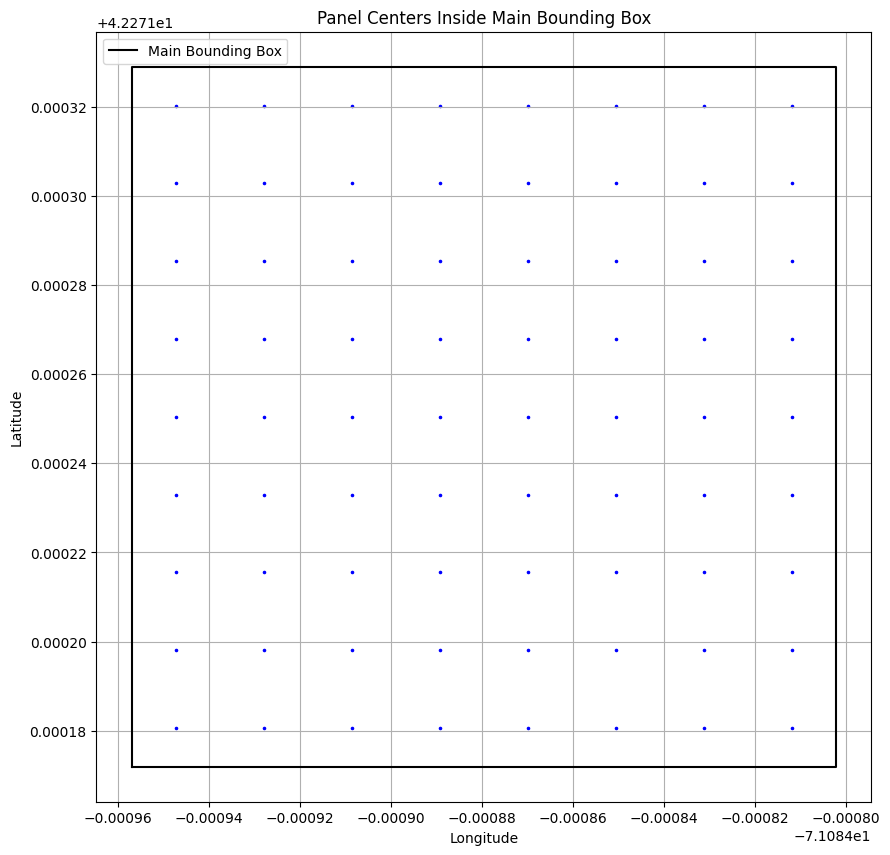

Total number of panels that can fit inside the main bounding box: 72


In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from math import radians, sin, cos, sqrt, atan2
def find_smallest_bounding_box(df):
    # Extract all latitudes and longitudes from the DataFrame
    all_lats = []
    all_lons = []
    for column in ['A', 'B', 'C', 'D']:
        all_lats.extend(df[column].apply(lambda x: x[0]))
        all_lons.extend(df[column].apply(lambda x: x[1]))

    # Find the min and max of latitudes and longitudes
    min_lat = min(all_lats)
    max_lat = max(all_lats)
    min_lon = min(all_lons)
    max_lon = max(all_lons)

    # SW and NE corners
    sw_corner = (min_lat, min_lon)
    ne_corner = (max_lat, max_lon)

    return sw_corner, ne_corner

box = find_smallest_bounding_box(df_results_1)

# Extract main bounding box
main_box = [
    box[0][0],
    box[0][1],
    box[1][0],
    box[1][1]
]
    

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Function to calculate the Haversine distance between two points on the Earth's surface
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 3958.8  # Radius of Earth in miles
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c  # Distance in miles
    return distance * 63360  # Convert to inches

# Function to calculate the number of panels that can fit inside a bounding box
def panels_in_bounding_box(bounding_box, panel_width, panel_height):
    sw_lat, sw_lon, ne_lat, ne_lon = bounding_box

    # Calculate the width and height of the bounding box in inches using Haversine formula
    width = haversine_distance(sw_lat, sw_lon, sw_lat, ne_lon)
    height = haversine_distance(sw_lat, sw_lon, ne_lat, sw_lon)

    # Calculate the number of panels that can fit
    panels_in_width = int(width // panel_width)
    panels_in_height = int(height // panel_height)
    total_panels = panels_in_width * panels_in_height

    return total_panels

# Function to calculate the panel centers
def calculate_panel_centers(bounding_box, panel_width, panel_height):
    sw_lat, sw_lon, ne_lat, ne_lon = bounding_box

    # Calculate the number of panels in width and height
    panels_in_width = int(haversine_distance(sw_lat, sw_lon, sw_lat, ne_lon) // panel_width)
    panels_in_height = int(haversine_distance(sw_lat, sw_lon, ne_lat, sw_lon) // panel_height)

    # Calculate the step size for panel centers
    lat_step = (ne_lat - sw_lat) / panels_in_height
    lon_step = (ne_lon - sw_lon) / panels_in_width

    # Calculate and store panel centers along with their latitudes and longitudes
    panel_centers = []
    for i in range(panels_in_height):
        for j in range(panels_in_width):
            center_lat = sw_lat + i * lat_step + lat_step / 2
            center_lon = sw_lon + j * lon_step + lon_step / 2
            panel_centers.append((center_lat, center_lon))
            #print(f"Panel Center {len(panel_centers)} - Latitude: {center_lat}, Longitude: {center_lon}")

    return panel_centers



# Calculate the number of panels that can fit inside the main bounding box
total_panels_in_main_box = panels_in_bounding_box(main_box, panel_width, panel_height)

# Calculate panel centers and print their latitudes and longitudes
panel_centers = calculate_panel_centers(main_box, panel_width, panel_height)

# Plotting code
plt.figure(figsize=(10, 10))
plt.plot([main_box[1], main_box[3], main_box[3], main_box[1], main_box[1]], 
         [main_box[0], main_box[0], main_box[2], main_box[2], main_box[0]], 'k-', label='Main Bounding Box')

# Plot panel centers
for center in panel_centers:
    plt.scatter(center[1], center[0], c='b', marker='.', s=10)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Panel Centers Inside Main Bounding Box')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
# Print the result
print("Total number of panels that can fit inside the main bounding box:", total_panels_in_main_box)

In [20]:
from math import radians, sin, cos, sqrt, atan2

# Function to calculate the Haversine distance between two points on the Earth's surface
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 3958.8  # Radius of Earth in miles
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c  # Distance in miles
    return distance * 63360  # Convert to inches

# Function to calculate distances between neighboring panel centers
def calculate_distances(panel_centers):
    num_centers = len(panel_centers)
    min_distances = {}

    for i in range(num_centers):
        for j in range(i + 1, num_centers):
            lat1, lon1 = panel_centers[i]
            lat2, lon2 = panel_centers[j]
            distance = haversine_distance(lat1, lon1, lat2, lon2)
            min_distances[(i, j)] = distance

    return min_distances


# Calculate minimum distances between neighboring panel centers in inches
distances = calculate_distances(panel_centers)

# Find the minimum distance
min_distance = min(distances.values())

# Print the minimum distance in inches
print(f"Minimum distance between neighboring panels: {min_distance} inches")

Minimum distance between neighboring panels: 62.68302364269658 inches


In [28]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# Declare panel_df as global
global panel_df

def assign_panel_numbers_and_colors(panel_centers, df):
    global panel_df  # Indicate that we are using the global variable
    panel_info = []
    panel_numbers = {}
    panel_colors = {}
    
    # Iterate over each panel center
    for i, panel_center in enumerate(panel_centers):
        lat, lon = panel_center
        assigned_sample = None
        highest_sample_height = -1
        
        # Iterate over each row in the DataFrame instead of a dictionary
        for index, row in df.iterrows():
            # Extract bounding box coordinates and sample height
            sw_lat, sw_lon = row['A'][0], row['A'][1]
            ne_lat, ne_lon = row['B'][0], row['B'][1]
            sample_height = row['Sampleheight']
            
            # Check if the panel center is within the bounding box
            if sw_lat <= lat <= ne_lat and sw_lon <= lon <= ne_lon:
                
                # Check if this is the highest sample so far
                if sample_height > highest_sample_height:
                    assigned_sample = index  # Use the DataFrame index as the sample name
                    highest_sample_height = sample_height

        # If a sample was assigned, record panel information
        if assigned_sample is not None:
            panel_number = len(panel_numbers) + 1
            panel_numbers[panel_center] = panel_number
            panel_colors[panel_center] = cm.tab20(i)
            panel_info.append([panel_number, assigned_sample, panel_center, highest_sample_height])
            
    panel_df = pd.DataFrame(panel_info, columns=['Panel Number', 'Sample Assigned', 'Panel Center', 'Panel Height'])
    
    # Filter out unassigned panels
    panel_df = panel_df[panel_df['Sample Assigned'].notna()]
    
    return panel_numbers, panel_colors

# Example usage
# Assuming 'df_results' is your DataFrame and 'panel_centers' is already defined
panel_numbers, panel_colors = assign_panel_numbers_and_colors(panel_centers, df_results_1)

# Access the global DataFrame for later use
print(panel_df)


    Panel Number  Sample Assigned                            Panel Center  \
0              1                8       (42.2711981185947, -71.084947325)   
1              2                8       (42.2711981185947, -71.084927975)   
2              3                8       (42.2711981185947, -71.084908625)   
3              4                0       (42.2711981185947, -71.084889275)   
4              5                0  (42.2711981185947, -71.08486992499999)   
5              6                0       (42.2711981185947, -71.084850575)   
6              7                0       (42.2711981185947, -71.084831225)   
7              8                0       (42.2711981185947, -71.084811875)   
8              9                8       (42.2712155600155, -71.084947325)   
9             10                8       (42.2712155600155, -71.084927975)   
10            11               10       (42.2712155600155, -71.084908625)   
11            12               10       (42.2712155600155, -71.084889275)   

In [31]:
def is_point_inside_polygon(point, polygon):
    """
    Determine if a point is inside a given polygon or not
    Polygon is a list of (x, y) pairs.
    """
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    b1 = sign(point, polygon[0], polygon[1]) < 0.0
    b2 = sign(point, polygon[1], polygon[2]) < 0.0
    b3 = sign(point, polygon[2], polygon[3]) < 0.0
    b4 = sign(point, polygon[3], polygon[0]) < 0.0

    return ((b1 == b2) and (b2 == b3) and (b3 == b4))

def assign_panel_numbers_and_colors(panel_centers, df):
    global panel_df
    panel_info = []
    panel_numbers = {}
    panel_colors = {}
    
    for i, panel_center in enumerate(panel_centers):
        lat, lon = panel_center
        assigned_sample = None
        highest_sample_height = -1
        
        for index, row in df.iterrows():
            # Define the rectangle as a list of (x, y) pairs
            rectangle = [row['A'],  row['C'], row['B'], row['D']]
            
            # Use the is_point_inside_polygon function to test if the panel center is within the rectangle
            if is_point_inside_polygon(panel_center, rectangle):
                sample_height = row['Sampleheight']
                if sample_height > highest_sample_height:
                    assigned_sample = index
                    highest_sample_height = sample_height

        if assigned_sample is not None:
            panel_number = len(panel_numbers) + 1
            panel_numbers[panel_center] = panel_number
            panel_colors[panel_center] = cm.tab20(i % 20)  # Using modulo to avoid index error
            panel_info.append([panel_number, assigned_sample, panel_center, highest_sample_height])
            
    panel_df = pd.DataFrame(panel_info, columns=['Panel Number', 'Sample Assigned', 'Panel Center', 'Panel Height'])
    panel_df = panel_df[panel_df['Sample Assigned'].notna()]
    
    return panel_numbers, panel_colors

# Example usage
panel_numbers, panel_colors = assign_panel_numbers_and_colors(panel_centers, df_results_1)
print(panel_df)


    Panel Number  Sample Assigned                            Panel Center  \
0              1                0       (42.2711806771740, -71.084889275)   
1              2                8       (42.2711981185947, -71.084947325)   
2              3                0       (42.2711981185947, -71.084889275)   
3              4                0  (42.2711981185947, -71.08486992499999)   
4              5               10       (42.2712155600155, -71.084908625)   
5              6               10       (42.2712155600155, -71.084889275)   
6              7                0       (42.2712155600155, -71.084850575)   
7              8                0       (42.2712155600155, -71.084831225)   
8              9                2       (42.2712330014362, -71.084908625)   
9             10               10       (42.2712330014362, -71.084889275)   
10            11               10  (42.2712330014362, -71.08486992499999)   
11            12                4       (42.2712330014362, -71.084850575)   

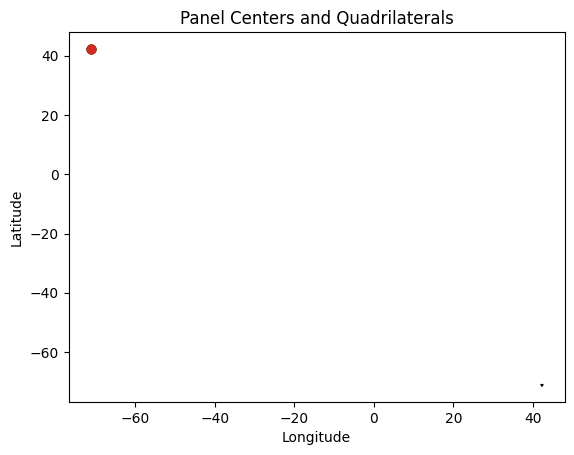

In [33]:
import matplotlib.pyplot as plt
from matplotlib import colormaps

def plot_panels_and_quadrilaterals(panel_df, df):
    # Create a new figure and axis for the plot
    fig, ax = plt.subplots()

    # Plot each quadrilateral
    for index, row in df.iterrows():
        rectangle = [row['A'],  row['C'], row['B'], row['D'], row['A']]  # Close the loop
        xs, ys = zip(*rectangle)  # Create lists of x and y values
        ax.plot(xs, ys, 'k-')  # Plot the rectangle with black line

    # Color map
    color_map = colormaps['tab20']  # Get a color map with enough colors

    # Plot each panel center
    for index, row in panel_df.iterrows():
        panel_center = row['Panel Center']
        sample_assigned = row['Sample Assigned']
        color = color_map(sample_assigned % 20)  # Get color based on the assigned sample
        ax.plot(panel_center[1], panel_center[0], 'o', color=color)  # Plot the panel center

    # Set labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Panel Centers and Quadrilaterals')

    # Show the plot
    plt.show()

# Example usage
plot_panels_and_quadrilaterals(panel_df, df_results_1)


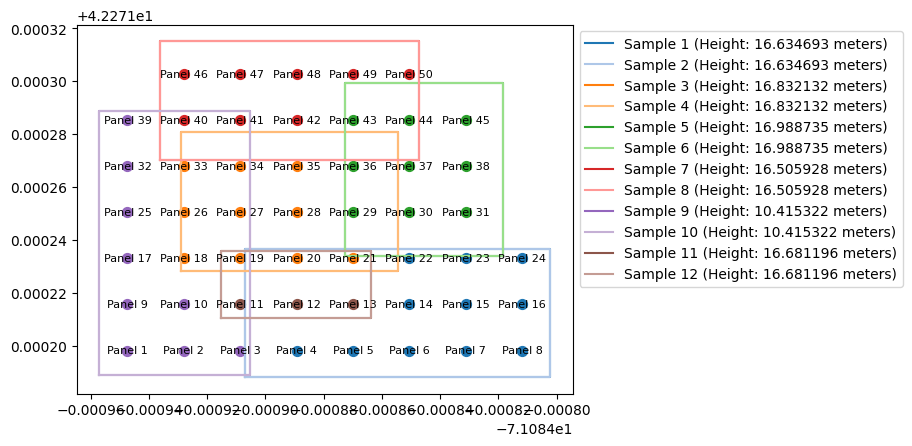

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# Assign panel numbers and colors based on the DataFrame
def assign_panel_numbers_and_colors(panel_centers, df):
    panel_numbers = {}
    panel_colors = {}

    for i, panel_center in enumerate(panel_centers):
        lat, lon = panel_center
        assigned_sample = None
        highest_sample_height = -1
        color_index = -1

        for index, row in df.iterrows():
            # Extract the coordinates and height from the DataFrame
            sw_lat, sw_lon = row['A'][0], row['A'][1]
            ne_lat, ne_lon = row['B'][0], row['B'][1]
            sample_height = row['Sampleheight']

            # Check if the panel center is within the current bounding box
            if sw_lat <= lat <= ne_lat and sw_lon <= lon <= ne_lon:
                if sample_height > highest_sample_height:
                    assigned_sample = index
                    highest_sample_height = sample_height
                    color_index = index

        if assigned_sample is not None:
            panel_number = len(panel_numbers) + 1
            panel_numbers[panel_center] = panel_number
            color = cm.tab20(color_index % 20)  # To avoid index error if color_index >= 20
            panel_colors[panel_center] = color

    return panel_numbers, panel_colors

# Plotting function
def plot_panels_and_boxes(panel_numbers, panel_colors, df):
    for panel_center, panel_number in panel_numbers.items():
        lat, lon = panel_center
        color = panel_colors.get(panel_center, 'blue')
        plt.scatter(lon, lat, c=[color], s=50)
        plt.annotate(f'Panel {panel_number}', (lon, lat), fontsize=8, color='black', ha='center', va='center')

    # Plot bounding boxes with unique colors
    for index, row in df.iterrows():
        sw_lat, sw_lon = row['A'][0], row['A'][1]
        ne_lat, ne_lon = row['B'][0], row['B'][1]
        color = cm.tab20(index % 20)
        sample_height = row['Sampleheight']
        plt.plot([sw_lon, ne_lon, ne_lon, sw_lon, sw_lon], [sw_lat, sw_lat, ne_lat, ne_lat, sw_lat], color=color, label=f'Sample {index+1} (Height: {sample_height} meters)')

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

# Example usage assuming 'panel_centers' is already defined and 'df_results' is your DataFrame
panel_numbers, panel_colors = assign_panel_numbers_and_colors(panel_centers, df_results)
plot_panels_and_boxes(panel_numbers, panel_colors, df_results)
